In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import xgboost as xgb
import joblib


In [2]:
# Load dataset
df = pd.read_csv("cleaned_data2_iotid23.csv")

# Define columns to drop
drop_cols = [
    "Protocol",
    "Idle Std",
    "Idle Mean",
    "Active Std",
    "Active Mean",
    "Fwd Seg Size Min",
    "Fwd Act Data Pkts",
    "Bwd Init Win Bytes",
    "FWD Init Win Bytes",
    "Bwd Bulk Rate Avg",
]

# Drop the specified columns
X = df.drop(
    columns=["Label"] + drop_cols, errors="ignore"
)  # Also dropping unnecessary columns
y = df["Label"]


In [3]:
import numpy as np
import pandas as pd

# Check for infinite values
print("Number of infinite values in X:", np.isinf(X).sum().sum())

# Replace infinite values with NaN (if any)
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for NaN values
print("Number of NaN values in X:", X.isna().sum().sum())

# Fill or drop NaN values
X.fillna(X.median(), inplace=True)  # Replace NaN with median values


Number of infinite values in X: 1830
Number of NaN values in X: 1830


In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [9]:
from imblearn.over_sampling import ADASYN,SMOTE

# adasyn = ADASYN(random_state=42, n_neighbors=2)
# X_resampled, y_resampled = adasyn.fit_resample(X_scaled, y)

smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [10]:
# Define Autoencoder Model
input_dim = X_train.shape[1]  # Number of features
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

In [11]:
# Build Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")

In [12]:
# Train Autoencoder
autoencoder.fit(
    X_train,
    X_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
)

Epoch 1/10
132382/132382 [==============================] - 210s 2ms/step - loss: 0.5175 - val_loss: 0.5297
Epoch 2/10
132382/132382 [==============================] - 177s 1ms/step - loss: 0.5168 - val_loss: 0.5297
Epoch 3/10
132382/132382 [==============================] - 183s 1ms/step - loss: 0.5168 - val_loss: 0.5297
Epoch 4/10
132382/132382 [==============================] - 168s 1ms/step - loss: 0.5168 - val_loss: 0.5297
Epoch 5/10
132382/132382 [==============================] - 169s 1ms/step - loss: 0.5168 - val_loss: 0.5297
Epoch 6/10
132382/132382 [==============================] - 196s 1ms/step - loss: 0.5168 - val_loss: 0.5297
Epoch 7/10
132382/132382 [==============================] - 202s 2ms/step - loss: 0.5168 - val_loss: 0.5297
Epoch 8/10
132382/132382 [==============================] - 244s 2ms/step - loss: 0.5168 - val_loss: 0.5297
Epoch 9/10
132382/132382 [==============================] - 197s 1ms/step - loss: 0.5168 - val_loss: 0.5297
Epoch 10/10
132382/132382 [=

In [13]:
# Extract encoded features
encoder = Model(inputs=input_layer, outputs=encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)


33096/33096 [==============================] - 36s 1ms/step


In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Fit on train labels
y_test_encoded = label_encoder.transform(y_test)  # Transform test labels

In [15]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_encoded)),
    random_state=42,
)

# Train on encoded labels
xgb_model.fit(X_train_encoded, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=12,
              num_parallel_tree=None, ...)

In [16]:
from sklearn.metrics import classification_report

# Convert y_test to integer labels
y_test_encoded = label_encoder.transform(y_test)  # Use the same label encoder


In [17]:
# Make predictions
y_pred = xgb_model.predict(X_test_encoded)

# Evaluate model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute and print classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))  # Both should be numeric


Accuracy: 0.9988

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     88254
           1       1.00      0.99      0.99     88254
           2       1.00      1.00      1.00     88254
           3       1.00      1.00      1.00     88255
           4       1.00      1.00      1.00     88254
           5       1.00      1.00      1.00     88254
           6       0.99      1.00      0.99     88255
           7       1.00      1.00      1.00     88255
           8       1.00      1.00      1.00     88254
           9       1.00      1.00      1.00     88254
          10       1.00      1.00      1.00     88254
          11       1.00      1.00      1.00     88254

    accuracy                           1.00   1059051
   macro avg       1.00      1.00      1.00   1059051
weighted avg       1.00      1.00      1.00   1059051



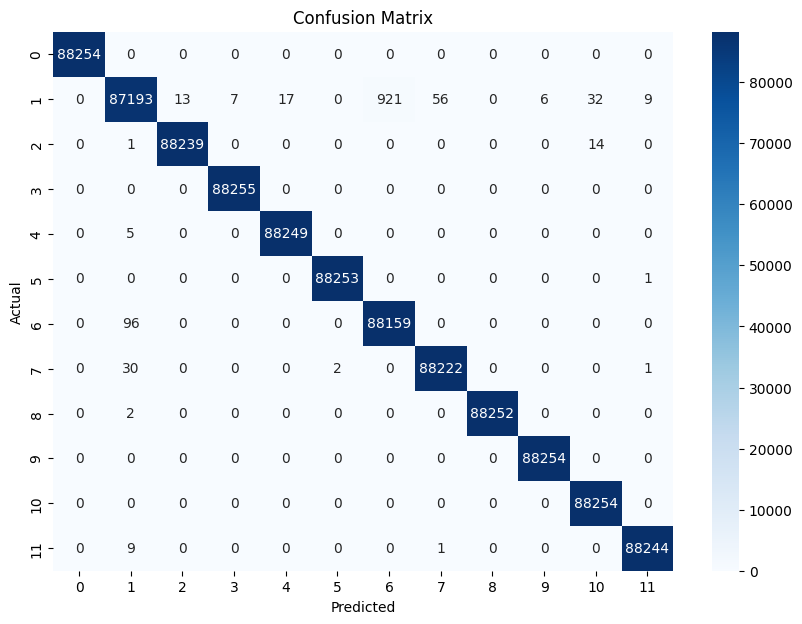

In [18]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

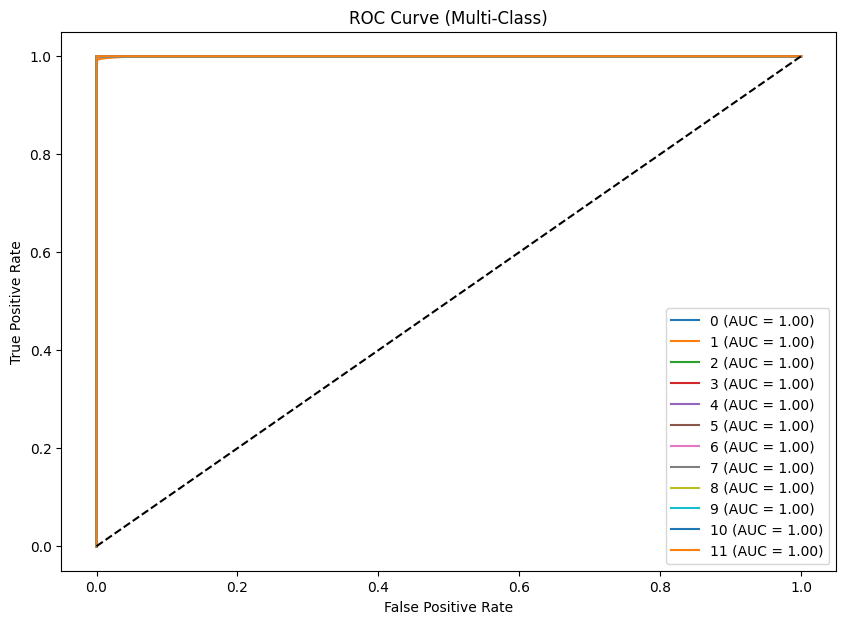

In [19]:
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC curve
y_test_binarized = label_binarize(
    y_test_encoded, classes=np.arange(len(label_encoder.classes_))
)
y_pred_proba = xgb_model.predict_proba(X_test_encoded)

# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-Class)")
plt.legend(loc="lower right")
plt.show()

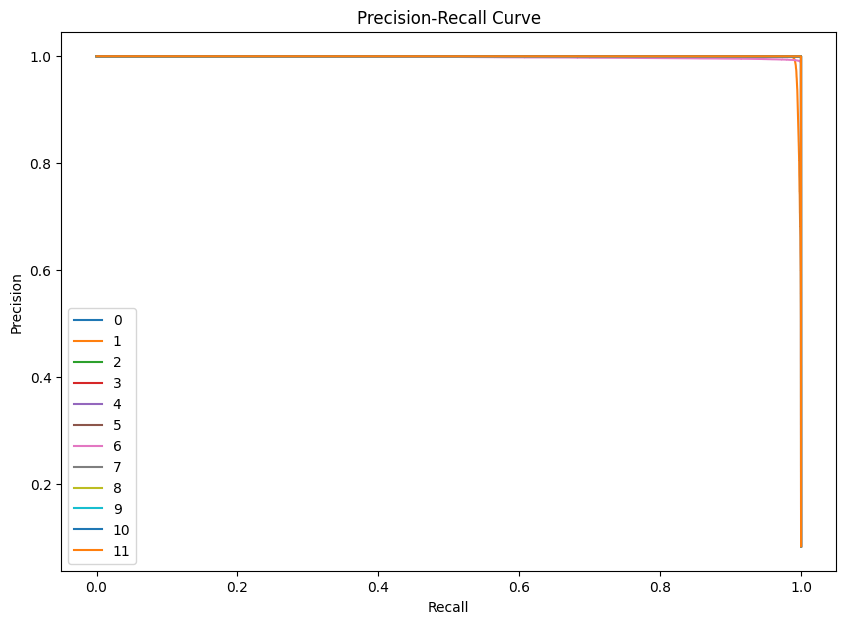

In [20]:
# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(
        y_test_binarized[:, i], y_pred_proba[:, i]
    )
    plt.plot(recall, precision, label=f"{class_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()